In [22]:
import numpy as np
import scipy as sp
%load_ext autoreload
%autoreload 2

# simulate data y~n(mu,sigma), mu~n(mu0,sig0)

In [3]:
p = 2
rho = 0.5
mu0 = np.ones([p,1])
sigma0 = np.identity(p)
sigma = np.array([[1,rho],[rho,1]])
n = 100
y = np.zeros([p,n])
for i in range(n):
    mn = np.random.multivariate_normal(mu0.ravel(),sigma0)
    obs = np.random.multivariate_normal(mn.ravel(),sigma)
    y[:,i] = obs

# get posterio distribution, analytically

In [4]:
ybar = np.reshape(np.mean(y,axis=-1),(2,1))
post_sig = np.linalg.inv((n*np.linalg.inv(sigma))+np.linalg.inv(sigma0))

def get_post_mean(mu0,sigma0,sigma,ybar,n):
    tmp1 = np.matmul(np.linalg.inv(sigma0),mu0)
    tmp2 = n*np.matmul(np.linalg.inv(sigma),ybar)
    tmp3 = np.matmul(post_sig,tmp1+tmp2)
    return tmp3
    
def get_rho(sigma):
    return sigma[1,0]/(np.sqrt(sigma[0,0])*np.sqrt(sigma[1,1]))


#post_sig = np.linalg.inv((n*np.matmul(np.linalg.inv(sigma),ybar))+np.linalg.inv(sigma0))
post_mean = get_post_mean(mu0,sigma0,sigma,ybar,n)
post_rho = get_rho(post_sig)
prior_rho = get_rho(sigma0)

print(post_mean)
print(get_rho(post_sig))
print(get_rho(sigma))

[[1.05104906]
 [1.20413752]]
0.49627791563275436
0.5


# estimate via ABC-Deep QR

# estimate posterior over MCMC using PyStan

In [10]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N; // sample size
    vector[2] mu0; // prior mean
    matrix[2, 2] sigma0; // prior cov
    matrix[2, 2] sigma; // data cov
    vector[2] y[N]; // bivariate data
}
parameters {
    vector[2] mu; // mean
}

model {
        mu ~ multi_normal(mu0, sigma0);
        y  ~ multi_normal(mu, sigma);
    }
"""

data = {'N': n, 'mu0': mu0.ravel(), 'sigma0': sigma0,'sigma':sigma,'y':np.transpose(y)}
# Compile the model
sm = pystan.StanModel(model_code=model)
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_df050683423f031e5be3801b91edcdd9 NOW.


In [16]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

/Users/soma/venvs/daggit/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


cor [[1.         0.49194796]
 [0.49194796 1.        ]]
mu_1 DescribeResult(nobs=2000, minmax=(0.7528433169677744, 1.3787783672599125), mean=1.05590357277572, variance=0.008838313401805789, skewness=0.09862119183805504, kurtosis=0.02127432527210038)
mu_2 DescribeResult(nobs=2000, minmax=(0.8503601447044671, 1.5759981229115847), mean=1.2062580319221043, variance=0.009518224025845427, skewness=0.028764980974027764, kurtosis=0.08266810219429255)


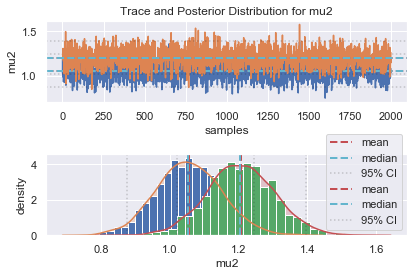

In [25]:
post_mu = fit['mu']
plot_trace(post_mu[:,0],param_name='mu1')
plot_trace(post_mu[:,1],param_name='mu2')
print('cor',np.corrcoef(np.transpose(post_mu)))
print('mu_1',sp.stats.describe(post_mu[:,0]))
print('mu_2',sp.stats.describe(post_mu[:,1]))